## 1 IMPORTAÇÃO DOS DADOS

In [120]:
import pandas as pd
import numpy as nps

dataset='random'
balancing=''
df = pd.read_csv(f'./../4_METRICS/8_output_merge3/{dataset}/datasetClass_with_foc_pmd_email_ss.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 2 PREPROCESSAMENTO DOS DADOS

#### 2.1 Dados ausentes ou corrompidos

- Atribuir média para NaN ou valores faltosos em classMetric_type

In [121]:
df['classMetric_lcom*'].describe()

count    4883.000000
mean        0.238298
std         0.339564
min         0.000000
25%         0.000000
50%         0.000000
75%         0.533333
max         1.000000
Name: classMetric_lcom*, dtype: float64

In [122]:
df['classMetric_lcom*'] = df['classMetric_lcom*'].fillna(df['classMetric_lcom*'].mean())

# plt.hist(df['classMetric_lcom*'], bins=
df['classMetric_lcom*'].sort_values(ascending=False).head(50)

1037    1.000000
3130    1.000000
965     1.000000
4096    1.000000
4087    1.000000
1584    1.000000
1397    1.000000
1255    1.000000
1269    1.000000
654     1.000000
1535    1.000000
3122    1.000000
657     1.000000
1516    1.000000
1146    1.000000
347     1.000000
3123    1.000000
1514    1.000000
1473    1.000000
1291    1.000000
3396    1.000000
3933    1.000000
2403    1.000000
3180    1.000000
950     1.000000
4067    1.000000
1461    1.000000
1305    1.000000
3911    1.000000
3913    1.000000
3131    1.000000
3932    1.000000
1319    1.000000
1125    1.000000
3914    1.000000
4070    1.000000
1241    1.000000
3930    1.000000
1762    1.000000
3081    0.991803
954     0.991525
971     0.991525
532     0.990196
530     0.990000
222     0.985760
180     0.985760
4177    0.983740
4165    0.983539
285     0.983539
301     0.983539
Name: classMetric_lcom*, dtype: float64

- Modifiers trocar -1 por 0, o dado -1 indica que não conseguiu computar, por esse motivo decidimos transformar -1 em 0.

In [123]:

df['classMetric_modifiers'] = df['classMetric_modifiers'].apply(lambda x: 0 if x == -1 else x)

# display(df['classMetric_modifiers'].value_counts())
# display(df)

#### 2.3 Dados Categóricos

- Aplicar Aplicar One-Hot Encoding na coluna operation(operações refatoração) e classMetric_type(tipo de dado)

In [124]:
df['operations2'] = df['operation'].apply(lambda x: x.replace("[",'').replace("]",'').replace("'",'').replace(", ",','))
df_encoded = df['operations2'].str.get_dummies(',')
df = pd.concat([df,df_encoded],axis=1)

df_types = pd.get_dummies(df['classMetric_type'], prefix='type')
df = pd.concat([df,df_types],axis=1)

# encoding_dic = {'enum':0,'anonymous': 1, 'innerclass':2, 'class':3,'interface':4 }
# df['classMetric_type'] = df['classMetric_type'].map(encoding_dic)

#### 2.4 Engenharia de Features

- Calcular LOCC - diferença de linhas alteradas depois da refatoração. 

In [125]:

def calculate_locc(row, df):
    if row['refactored'] == 1:
        # Encontra a linha anterior com o mesmo 'classMetric_class' e 'refactored' igual a 0
        previous_rows = df[(df['classMetric_class'] == row['classMetric_class']) & (df['refactored'] == 0) & (df.index < row.name)]
        previous_loc = previous_rows.iloc[-1]['classMetric_loc'] if not previous_rows.empty else 0
        row['locc'] = row['classMetric_loc'] - previous_loc
    else:
        row['locc'] = 0
    return row

# Aplica a função calculate_locc para cada grupo e cria a nova coluna 
# aux=[]
df = df.apply(calculate_locc, args=(df,), axis=1)

# display(aux[[ 'classMetric_class','refactored','classMetric_loc','locc']].tail(20))

- Calcular Diff McCabe's complexity, Métrica DCC

In [126]:

def calculate_dcc(row, df):
    if row['refactored'] == 1:
        # Encontra a linha anterior com o mesmo 'classMetric_class' e 'refactored' igual a 0
        previous_rows = df[(df['classMetric_class'] == row['classMetric_class']) & (df['refactored'] == 0) & (df.index < row.name)]
        previous_loc = previous_rows.iloc[-1]['classMetric_wmc'] if not previous_rows.empty else 0
        row['dcc'] = row['classMetric_wmc'] - previous_loc
    else:
        row['dcc'] = 0
    return row

# Aplica a função calculate_locc para cada grupo e cria a nova coluna 
df = df.apply(calculate_dcc, args=(df,), axis=1)

- Configurar Score de Similaridade antes da refatoracao

In [127]:
df.loc[df['refactored'] == 0, 'ss'] = 0

- Remover colunas que não serão usadas ou que já foram processadas

In [128]:
df = df.drop(columns=['commit','operation','operations2','project','classMetric_file','classMetric_file2','file','file2','classMetric_class','classMetric_synchronizedFieldsQty','classMetric_type','classMetric_cbo','classMetric_lcom','classMetric_file','classMetric_tcc','classMetric_lcc','cs_before','cs_after','issues_after','issues_before','emails'])

In [129]:
df.columns.value_counts

<bound method IndexOpsMixin.value_counts of Index(['refactored', 'classMetric_cboModified', 'classMetric_fanin',
       'classMetric_fanout', 'classMetric_wmc', 'classMetric_dit',
       'classMetric_noc', 'classMetric_rfc', 'classMetric_lcom*',
       'classMetric_totalMethodsQty',
       ...
       'Split Class', 'Split Package', 'Split Parameter', 'type_anonymous',
       'type_class', 'type_enum', 'type_innerclass', 'type_interface', 'locc',
       'dcc'],
      dtype='object', length=147)>

- [ Remover 13 por sugestões de desenvolvedores ] mas 'classMetric_Path of Class' já foram removidas antes 'File Type' então 11,

In [130]:
# df = df.drop(columns=['classMetric_nosi', 'classMetric_rfc','classMetric_returnQty','classMetric_parenthesizedExpsQty','classMetric_stringLiteralsQty', 'classMetric_numbersQty', 'classMetric_mathOperationsQty',	'classMetric_innerClassesQty',	'classMetric_uniqueWordsQty', 'classMetric_logStatementsQty', 'classMetric_modifiers'])

In [131]:
# from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,Normalizer
# from numpy import log1p
# scaler = Normalizer()
# scaler = MinMaxScaler((0,1))

# df[column] = scaler.fit_transform(df[[column]])
# df[column] = df[column].round(1)
# column='classMetric_cboModified'
# df[column] = np.log1p(df[column])

In [132]:
#reduzir outliers

# colunas = df.iloc[:,:50]  # Para todas as colunas, ou especifique uma lista de colunas
# def outlier():
#     colunas = df.iloc[:,1:52].columns
#     for coluna in colunas:
#         Q1 = df[coluna].quantile(0.25)
#         Q3 = df[coluna].quantile(0.75)
#         IQR = Q3 - Q1
#         limite_inferior = Q1 - 1.5 * IQR
#         limite_superior = Q3 + 1.5 * IQR
#         # df = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
#         # df = df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]
#             # Ajustando os outliers para o limite superior
#         df[coluna] = df[coluna].apply(lambda x: limite_superior if x > limite_superior else x)
#         df[coluna] = df[coluna].apply(lambda x: limite_inferior if x < limite_superior else x)

# outlier()

- Calcular Index

In [133]:
#STEP 1 - Normalizar features para escala 0-1
def scaleMM(df, column, inverse=False):

    min_val = df[column].min()
    max_val = df[column].max()
    aux = df[column]

    # menorMelhor
    if inverse:
        scaled_column = df[column].apply(
            lambda x: (max_val - x) / (max_val - min_val))
    # maiorMelhor
    else:
        scaled_column = df[column].apply(
            lambda x: (x - min_val) / (max_val - min_val))

    return scaled_column


dfForIndex = pd.DataFrame()
for column in df.columns:

    # retornar escala no scaleMM quando MAIOR É MELHOR
    if column in [
        'classMetric_noc',
        'classMetric_nosi',
        'classMetric_totalFieldsQty',
        'classMetric_totalMethodsQty', 
        'classMetric_variablesQty',
        'classMetric_defaultFieldsQty',
        'classMetric_staticFieldsQty', 'classMetric_publicFieldsQty',
        'classMetric_privateFieldsQty', 'classMetric_protectedFieldsQty',
        'classMetric_staticMethodsQty',
        'classMetric_publicMethodsQty', 'classMetric_privateMethodsQty',
        'classMetric_protectedMethodsQty', 'classMetric_defaultMethodsQty',
        'classMetric_visibleMethodsQty', 'classMetric_abstractMethodsQty',
        'classMetric_finalMethodsQty', 'classMetric_finalFieldsQty', 
        'classMetric_uniqueWordsQty',
        'classMetric_mathOperationsQty',
        'classMetric_modifiers',
        'classMetric_assignmentsQty',
        'classMetric_logStatementsQty', 
        'foc7', 'foc14', 'foc21', 'foc28'
        ]:
        dfForIndex = pd.concat([dfForIndex, scaleMM(df, column)], axis=1)

    elif column in ['classMetric_cboModified',
                    'classMetric_fanin',
                    'classMetric_fanout',
                    'classMetric_dit',
                    'classMetric_rfc',
                    'classMetric_wmc',
                    'classMetric_loc',
                    'classMetric_lcom*',
                    'classMetric_returnQty',
                    'classMetric_comparisonsQty',
                    'classMetric_tryCatchQty',
                    'classMetric_stringLiteralsQty',
                    'classMetric_maxNestedBlocksQty',
                    'classMetric_anonymousClassesQty',
                    'classMetric_innerClassesQty',
                    'classMetric_lambdasQty',
                    'classMetric_synchronizedMethodsQty',
                    'classMetric_parenthesizedExpsQty',
                    'classMetric_loopQty',
                    'classMetric_numbersQty',
                    'cs', 'issues', 'locc', 'dcc'
                    ]:
        dfForIndex = pd.concat([dfForIndex, scaleMM(df, column, True)], axis=1)

    else:
        pass


#adicionar coluna 'ss' do df no dfForIndex para contabilizar no cálculo do aspecto complexidade
dfForIndex['ss'] = df['ss']
dfForIndex = dfForIndex.fillna(0)


In [134]:
#STEP 2 - Calcular index por aspectos 
#  dfForIndex[['classMetric_noc']].sort_values(by='classMetric_noc', ascending=False)
from sklearn.preprocessing import MinMaxScaler


a_risk_list = []
a_speed_list = []
a_complexity_list = []



for index, row in dfForIndex.iterrows():
    sum_complexity=0
    sum_speed=0
    sum_risk=0
    for column in dfForIndex.columns:
        if column in ['dcc', 'cs', 'issues']:
            sum_risk += row[column]
        elif column in ['locc','foc7', 'foc14', 'foc21', 'foc28']:
            sum_speed += row[column]
        else:
            sum_complexity += row[column]
    a_risk = sum_risk/3;
    a_risk_list.append(a_risk)
    a_speed = sum_speed/5;
    a_speed_list.append(a_speed)
    a_complexity = sum_complexity/(len(dfForIndex.columns)-8)
    a_complexity_list.append(a_complexity)




dfForIndex['a_risk'] = a_risk_list
dfForIndex['a_speed'] = a_speed_list
dfForIndex['a_complexity'] = a_complexity_list
dfForIndex['index'] = (dfForIndex['a_risk'] + dfForIndex['a_speed'] + dfForIndex['a_complexity'])/3


# # imprimir min e max de cada aspecto e do index
print('Aspecto Risk:', dfForIndex['a_risk'].min(), '-', dfForIndex['a_risk'].max())
print('Aspecto Speed:', dfForIndex['a_speed'].min(), '-', dfForIndex['a_speed'].max())
print('Aspecto Complexity:', dfForIndex['a_complexity'].min(), '-', dfForIndex['a_complexity'].max()) # max aumentou com a sintetização das colunas de metodos e fields.
print('Index:', dfForIndex['index'].min(), '-', dfForIndex['index'].max())


# Convertendo o array numpy de volta para um DataFrame e atualizando as colunas originais
#remove aspectos
dfForIndex = dfForIndex.drop(columns=['a_risk','a_speed','a_complexity'])



Aspecto Risk: 0.31197752853440947 - 0.9775819437026487
Aspecto Speed: 3.1497614982564445e-06 - 0.9628294036061027
Aspecto Complexity: 0.3464934305558487 - 0.539561132500894
Index: 0.2570131790078461 - 0.8016825115157035


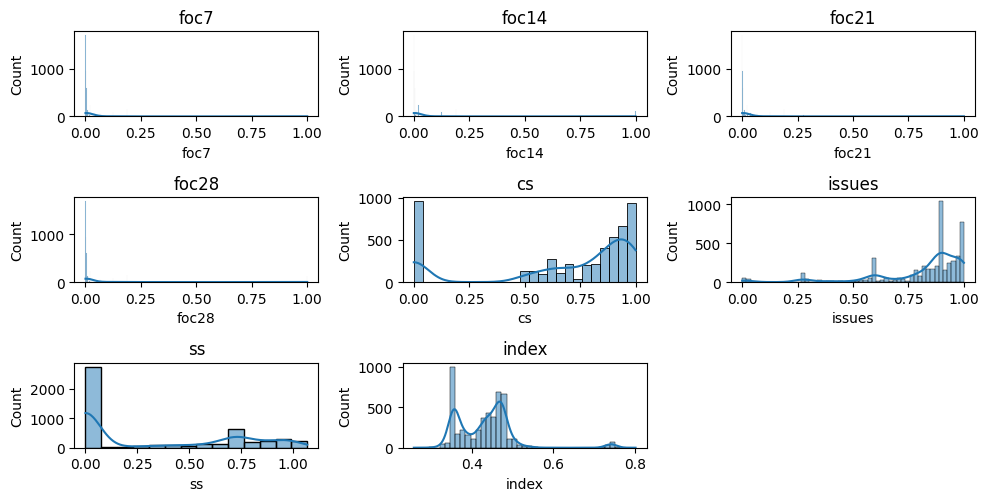

In [135]:

import matplotlib.pyplot as plt
import seaborn as sns

# plt.hist(dfForIndex['index'], bins=10)
# exbir dispersão dos dados

plt.figure(figsize=(10, 8)) 

colunas = ['foc7','foc14','foc21','foc28','cs','issues','ss', 'index'] 
for i, coluna in enumerate(colunas):
    plt.subplot(5, 3, i+1)
    # sns.boxplot(x=df[coluna], orient='h')
    sns.histplot(dfForIndex[coluna], kde=True)
    plt.title(coluna)
plt.tight_layout()
plt.show()

r_index: 100%|##########| 83/83 [00:00<00:00, 720.07it/s]


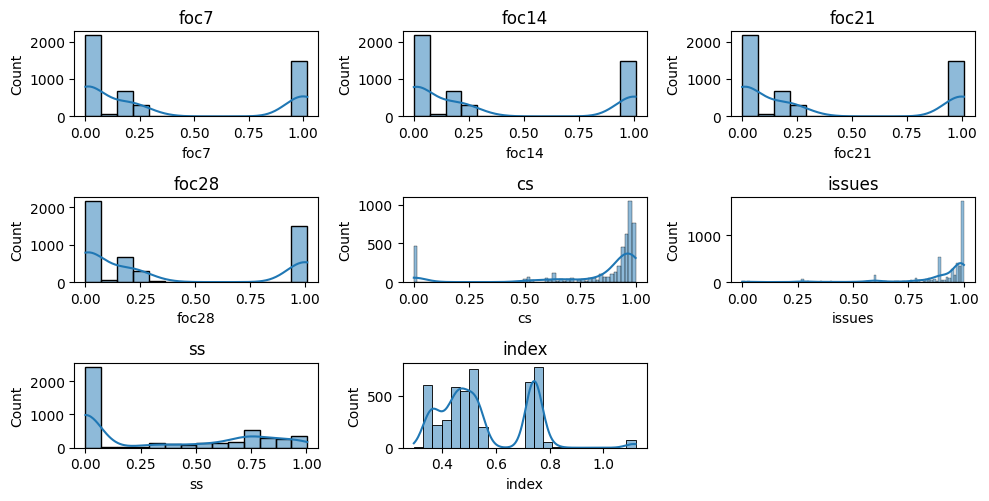

In [136]:
import smogn
#https://proceedings.mlr.press/v74/branco17a/branco17a.pdf

dfForIndex = smogn.smoter(data = dfForIndex, y = 'index' )
balancing = '-smogn'


plt.figure(figsize=(10, 8)) 

colunas = ['foc7','foc14','foc21','foc28','cs','issues','ss', 'index'] 
for i, coluna in enumerate(colunas):
    plt.subplot(5, 3, i+1)
    # sns.boxplot(x=df[coluna], orient='h')
    sns.histplot(dfForIndex[coluna], kde=True)
    plt.title(coluna)
plt.tight_layout()
plt.show()



In [137]:
# Adicionar outras colunas binárias
features_operation = [
    'refactored',
    'Add Attribute Annotation', 'Add Attribute Modifier',
    'Add Class Annotation', 'Add Class Modifier',
    'Add Method Annotation', 'Add Method Modifier', 'Add Parameter',
    'Add Parameter Annotation', 'Add Parameter Modifier',
    'Add Thrown Exception Type', 'Add Variable Modifier',
    'Change Attribute Access Modifier', 'Change Attribute Type',
    'Change Class Access Modifier', 'Change Method Access Modifier',
    'Change Parameter Type', 'Change Return Type',
    'Change Thrown Exception Type', 'Change Type Declaration Kind',
    'Change Variable Type', 'Collapse Hierarchy',
    'Encapsulate Attribute', 'Extract And Move Method',
    'Extract Attribute', 'Extract Class', 'Extract Interface',
    'Extract Method', 'Extract Subclass', 'Extract Superclass',
    'Extract Variable', 'Inline Method', 'Inline Variable',
    'Invert Condition', 'Localize Parameter', 'Merge Attribute',
    'Merge Catch', 'Merge Class', 'Merge Conditional', 'Merge Package',
    'Merge Parameter', 'Merge Variable', 'Modify Attribute Annotation',
    'Modify Class Annotation', 'Modify Method Annotation',
    'Move And Inline Method', 'Move And Rename Attribute',
    'Move And Rename Class', 'Move And Rename Method',
    'Move Attribute', 'Move Class', 'Move Code', 'Move Method',
    'Move Package', 'Move Source Folder', 'Parameterize Attribute',
    'Parameterize Variable', 'Pull Up Attribute', 'Pull Up Method',
    'Push Down Attribute', 'Push Down Method',
    'Remove Attribute Annotation', 'Remove Attribute Modifier',
    'Remove Class Annotation', 'Remove Class Modifier',
    'Remove Method Annotation', 'Remove Method Modifier',
    'Remove Parameter', 'Remove Parameter Annotation',
    'Remove Parameter Modifier', 'Remove Thrown Exception Type',
    'Remove Variable Modifier', 'Rename Attribute', 'Rename Class',
    'Rename Method', 'Rename Package', 'Rename Parameter',
    'Rename Variable', 'Reorder Parameter',
    'Replace Anonymous With Class', 'Replace Anonymous With Lambda',
    'Replace Attribute', 'Replace Attribute With Variable',
    'Replace Loop With Pipeline', 'Replace Variable With Attribute',
    'Split Attribute', 'Split Class', 'Split Package',
    'Split Parameter'
]

for column in df.columns:
    if column in features_operation:
        dfForIndex[column] = df[column]
# Atribuir 0 para as colunas especificadas onde refactored é 0
dfForIndex.loc[dfForIndex['refactored'] == 0, features_operation] = 0

### Grafico de caixa - box plot

In [138]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# Box plot usando seaborn
# plt.figure(figsize=(7, 6))
# sns.boxplot(data=dfForIndex[['dcc']], orient='h')
# sns.boxplot(data=dfForIndex[['cs']], orient='h')
# sns.boxplot(data=dfForIndex[['issues']], orient='h')
# plt.title('Box Plot of Features')
# plt.show()

In [139]:
# Histograma usando seaborn
# sns.histplot(dfForIndex['a_complexity'], bins=10, color='blue', alpha=0.7)
# sns.histplot(dfForIndex['a_risk'], bins=10, color='red', alpha=0.7)
# plt.title('Histogram using Seaborn')
# plt.show()

In [140]:
# sns.scatterplot(data=dfForIndex, x='a_complexity', y='a_complexity', color='red')
# plt.title('Scatter Plot using Seaborn')
# plt.show()

In [141]:
#Verificando se ainda tem NaN
for column in dfForIndex.columns:
    if dfForIndex[column].isnull().sum() > 0:
        print(column)

print(dfForIndex.shape)

# Verificar informações gerais do dataset
print(dfForIndex.info())

# Estatísticas descritivas
# print(dfForIndex.describe())

(4721, 143)
<class 'pandas.core.frame.DataFrame'>
Index: 4721 entries, 0 to 4919
Columns: 143 entries, classMetric_cboModified to Split Parameter
dtypes: float64(54), int64(89)
memory usage: 5.2 MB
None


## Treinamento do modelo

In [142]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


#1 - PREPARAR DADOS - X e y
# dfForIndex = dfForIndex.sample(frac=1, random_state=42).reset_index(drop=True)




dfForIndex = dfForIndex.astype(float).round(2)
x = dfForIndex.drop(columns=['index'], axis=1)
y = dfForIndex['index']

#2 - DIVIDIR DADOS - TREINO E TESTE
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [143]:
import numpy as np
from sklearn.metrics import r2_score


def mape(y_test, y_pred): 
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def adjusted_r2(y_test, y_pred,X_train):
  adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) / (len(y_test) - X_train.shape[1] - 1))
  return adj_r2

In [144]:
from joblib import load
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

def salvar_resultados(modelo, resultados):
    caminho_arquivo = f'./modelosFull/smong/resultados-{dataset}-{modelo}-smogn.json'  # Define o caminho do arquivo de resultados
    with open(caminho_arquivo, 'r') as arquivo:
        dados_existentes = json.load(arquivo)

    novos_dados=[]
    novos_dados.append(dados_existentes)
    novos_dados.append(resultados)

    with open(caminho_arquivo, 'w') as arquivo:
        json.dump(novos_dados, arquivo, indent=4)

# Substitua 'caminho/do/modelo.pkl' pelo caminho do seu arquivo de modelo
modelos = ['DecisionTreeRegressor', 'ElasticNet', 'GradientBoostingRegressor', 'Lasso', 'LinearRegression', 'RandomForestRegressor', 'Ridge','XGBRegressor']
for modelo in modelos:
    resultados = {}
    try:
        with open(f'./modelosFull/smong/modelo-{dataset}-{modelo}-smogn.pkl', 'rb') as file:
            modeloTreinado = load(file)
        y_pred = modeloTreinado.predict(x_test)
        mape_result = mape(y_test, y_pred)
        r2adj = adjusted_r2(y_test, y_pred, x_train)
        resultados = {'mape': mape_result, 'r2_ajustado': r2adj}
        salvar_resultados(modelo, resultados)
    except FileNotFoundError:
        print(f'Arquivo ./modelos/{dataset}/modelo-{dataset}-{modelo}-smong.pkl não encontrado')       

    

In [28]:
import json

modelos = ['LinearRegression','Ridge','ElasticNet','DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
i=0
dataset='random'        
for i in range(len(modelos)):
        try:
                with open(f'./modelos/{dataset}/resultados-{dataset}-{modelos[i]}-smogn.json', 'r') as file:
                        result = json.load(file)
                        
                        # print(f"DATASET: {dataset}")
                        print(
                                # f"modelo: {modelos[i]}\n"
                             f"{result[0]['MSE']:.4f}\n"
                             f"{result[0]['RMSE']:.4f}\n"
                             f"{result[0]['MAE']:.4f}\n"
                             f"{result[1]['mape']:.4f}\n"
                             f"{result[0]['R2']:.4f}\n"
                             f"{result[1]['r2_ajustado']:.4f}")
                        # print(f"modelo: {modelos[i]}\n"
                        #      f"MSE:    {result[0]['MSE']:.4f}\n"
                        #      f"RMSE:   {result[0]['RMSE']:.4f}\n"
                        #      f"MAE:    {result[0]['MAE']:.4f}\n"
                        #      f"MAPE:   {result[1]['mape']:.4f}\n"
                        #      f"R2:     {result[0]['R2']:.4f}\n"
                        #      f"R2A:    {result[1]['r2_ajustado']:.4f}")

        except FileNotFoundError:
                print(f'Arquivo ./modelos/{dataset}/modelo-{dataset}-{modelo}-smong.pkl não encontrado')       


0.0032
0.0564
0.0273
4.3312
0.8792
0.8596
0.0032
0.0565
0.0265
4.1952
0.8785
0.8592
0.0047
0.0688
0.0318
5.3722
0.8199
0.7860
0.0012
0.0350
0.0084
1.2251
0.9535
0.9526
0.0008
0.0285
0.0075
1.0637
0.9691
0.9610
0.0008
0.0275
0.0085
1.3346
0.9713
0.9590
0.0008
0.0281
0.0087
1.2676
0.9700
0.9599
